In [65]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

6. We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for
the standard errors of the income and balance logistic regression coefficients in two different ways: (1) using the bootstrap, and (2) using
the standard formula for computing the standard errors in the glm()
function. Do not forget to set a random seed before beginning your
analysis

(a) Using the summary() and glm() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [66]:
default = pd.read_csv("Data-Default.csv", index_col=0)
print(default.shape)
default.head()

(10000, 4)


,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


In [67]:
encoding_dict = {"Yes":1, "No":0}
default["default"] = default["default"].map(encoding_dict)
default.head()

,default,student,balance,income
1,0,No,729.526495,44361.625074
2,0,Yes,817.180407,12106.134700
3,0,No,1073.549164,31767.138947
4,0,No,529.250605,35704.493935
5,0,No,785.655883,38463.495879


In [68]:
X = default[["balance", "income"]]
X = sm.add_constant(X)
y = default["default"]
X.head()

,const,balance,income
1,1.0,729.526495,44361.625074
2,1.0,817.180407,12106.134700
3,1.0,1073.549164,31767.138947
4,1.0,529.250605,35704.493935
5,1.0,785.655883,38463.495879


In [69]:
results = sm.Logit(y,X).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Feb 2021   Pseudo R-squ.:                  0.4594
Time:                        23:36:06   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
balance        0.0056      0

In [70]:
(np.exp(0.0056)-1)*100

0.5615709310356376

In [71]:
(np.exp(2.081*10**-5)-1)*100

0.002081021652955428

The standard error of balance is 0.5616 and the standard error of income is 0.00208.

(b) Write a function, boot.fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [72]:
def get_indices(data, num_samples):
    positive_data = data[data["default"]==1]
    negative_data = data[data["default"]==0]
    
    positive_indices = np.random.choice(positive_data.index, int(num_samples/4), replace=True)
    negative_indices = np.random.choice(negative_data.index, int(3*num_samples/4), replace=True)
    total = np.concatenate([positive_indices, negative_indices])
    np.random.shuffle(total)
    return total

In [73]:
def boot(data, func, R):
    total_coeff_balance = []
    total_coeff_income = []
    for i in range(R):
        bootstrap = resample(data, replace=True, n_samples=(0.3*default.size), random_state=1, stratify = data['default'])
        params = func(data, bootstrap.index)
        total_coeff_balance.append(params[0])
        total_coeff_income.append(params[1])
    return (np.mean(total_coeff_balance), np.mean(total_coeff_income))
    

In [74]:
def boot_fn(data, index):
    X = data[["balance", "income"]].loc[index]
    y = data["default"].loc[index]
    
    lr = LogisticRegression()
    lr.fit(X, y)
    intercept = lr.intercept_
    coef_balance = lr.coef_[0][0]
    coef_income = lr.coef_[0][1]
    return [intercept,coef_balance, coef_income]

(c) Use the boot() function together with your boot.fn() function to
estimate the standard errors of the logistic regression coefficients
for income and balance.

In [75]:
intercept, coef_balance, coef_income = boot_fn(default, get_indices(default, 100))

print(f'Intercept is {intercept}, the coeff of balance is {coef_balance}, and the coeff of income is {coef_income}')

Intercept is [-7.42836654e-09], the coeff of balance is 0.00230419241395492, and the coeff of income is -0.00010973755734612088


(d) Comment on the estimated standard errors obtained using the
glm() function and using your bootstrap function.

They are similar, but not exactly the same. However, the fact that they're as similar as they are demonstrates how powerful bootstrapping can be in estimating variability.

8. We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set as follows:
> set.seed(1)
> x=rnorm(100)
> y=x-2*x^2+rnorm (100)

In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.

In [76]:
np.random.seed(1)

X = np.random.normal(size = 100)
y = X-2*(X ** 2) + np.random.normal(size = 100)

8 (b) Create a scatterplot of X against Y . Comment on what you find.

Text(0.5, 1.0, 'Scatter Plot')

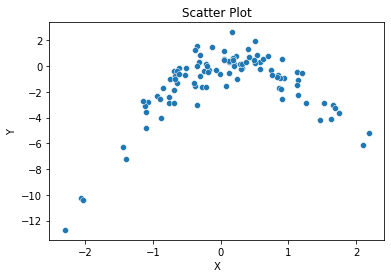

In [77]:
sns.scatterplot(X,y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot")

The plot appears to show a quadratic function affected by some random noise. This is not surprising, as the function we input into y was simply a quadratic function of X, with some random noise added.

8 (c) Set a random seed, and then compute the LOOCV errors that
result from fitting the following four models using least squares:
$$i. Y = \beta0 + \beta1X +\epsilon$$
$$ii. Y = \beta0 + \beta1X + \beta2X^2 +\epsilon$$
$$iii. Y = \beta0 + \beta1X + \beta2X^2 + \beta3X^3 +\epsilon$$
$$iv. Y = \beta0 + \beta1X + \beta2X^2 + \beta3X^3 + \beta4X^4 + \epsilon$$
Note you may find it helpful to use the data.frame() function
to create a single data set containing both X and Y .

In [78]:
np.random.seed(1)
for i in range(1,5):
    poly = PolynomialFeatures(i, include_bias=False)
    predictors = poly.fit_transform(X.reshape(-1,1))
    
    lr = LinearRegression()
    error = -1*cross_val_score(lr, predictors, y, cv=len(X), scoring ="neg_mean_squared_error").mean()
    print(f'For model{i}, error is {error}')

For model1, error is 6.260764331604616
For model2, error is 0.9142897072803657
For model3, error is 0.9268768781648801
For model4, error is 0.8669116865881077


(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

In [79]:
np.random.seed(42)
for i in range(1,5):
    poly = PolynomialFeatures(i, include_bias=False)
    predictors = poly.fit_transform(X.reshape(-1,1))
    
    lr = LinearRegression()
    error = -1*cross_val_score(lr, predictors, y, cv=len(X), scoring ="neg_mean_squared_error").mean()
    print(f'For model{i}, error is {error}')

For model1, error is 6.260764331604616
For model2, error is 0.9142897072803657
For model3, error is 0.9268768781648801
For model4, error is 0.8669116865881077


The LOOCV errors are identical. This makes sense because the random seed doesn't change the underlying math of LOOCV; there is no random sampling. LOOCV is set up to iterate through the entire data set, leaving out each observation out of the training set exactly once. Because every observation is left out exactly once regardless of random seed, altering the seed does not change the LOOCV error

(e) Which of the models in (c) had the smallest LOOCV error? Is
this what you expected? Explain your answer.

The lowest LOOCV error is in the 2nd degree polynomial estimate. This makes sense because our underlying function is 2nd degree. Even if we didn't know the underlying function, visual inspection of the scatterplot is highly suggestive of a quadratic function.

(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?

In [80]:
for i in range(1,5):
    poly = PolynomialFeatures(i)
    predictors = poly.fit_transform(X.reshape(-1,1))
    
    results = sm.OLS(y, predictors).fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.997
Date:                Thu, 25 Feb 2021   Prob (F-statistic):            0.00209
Time:                        23:36:33   Log-Likelihood:                -228.87
No. Observations:                 100   AIC:                             461.7
Df Residuals:                      98   BIC:                             466.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4131      0.242     -5.849      0.0

In each of the models, X is significant at the p<0.05 level. $X^2$ is also significant at the p<0.05 level in models 2-5. However, $X^3$ and $X^4$ are not significant at the p<0.05 level in any of the models they are in.

This is consistent with the cross-validation results, in that the LOOCV showed that model 2, which included only X and $X^2$, had the lowest error. As we add higher level predictors, we are increasing the variablity/noise of our estimates, but not necessarily gaining any additional accuracy when predicting the test observation. 

11. We will now try to predict per capita crime rate in the Boston data
set.
(a) Try out some of the regression methods explored in this chapter,
such as best subset selection, the lasso, ridge regression, and
PCR. Present and discuss results for the approaches that you
consider.

Use best subset, forward stepwise, & backwards stepwise selection

In [81]:
from sklearn.datasets import load_boston
boston = load_boston()

In [82]:
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [83]:
predictors = data.drop("CRIM", axis=1)
y=data["CRIM"]
predictors.head()

,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [86]:
boston = load_boston()
data = pd.DataFrame(boston.data,columns = boston.feature_names)
X = data.drop('CRIM',axis = 1)
y = data['CRIM']

lin_reg = LinearRegression()

### Best Subset ###

P = len(X.columns)
used_pred = []
M = []
M_scores = []
shrinking_subset = list(X.columns)
predictors = []

for K in range(1, P+1):
    #predictors = []
    for combination in it.combinations(X.columns, K):
        #print("combination = ", combination,"\n")
        predictors.append(combination)
        #print("predictors = ", predictors,"\n")

combo_set = set(predictors)
for combo in combo_set:
    combo
    score = np.mean(cross_val_score(lin_reg, X[list(combo)], y, cv = 5, scoring = 'neg_mean_squared_error'))
    #print("score = ", score, "\n")
    M.append(combo)
    M_scores.append(score)                             
best_M = M_scores.index(max(M_scores))
print('Best Subset - Predictors that make the best model are: ', M[best_M], 'with a score of ', max(M_scores))


Best Subset - Predictors that make the best model are:  ('ZN', 'NOX', 'DIS', 'RAD', 'LSTAT') with a score of  -44.048606471148375


Best Subset - Predictors that make the best model are:  ('ZN', 'NOX', 'DIS', 'RAD', 'LSTAT') with a score of  -44.048606471148375

In [87]:
boston = load_boston()
data = pd.DataFrame(boston.data,columns = boston.feature_names)
X = data.drop('CRIM',axis = 1)
y = data['CRIM']

lin_reg = LinearRegression()

### Forward Selection ###

P = len(X.columns)
used_pred = []
M = []
M_scores = []

for K in range(P):
    best_score = -1000
    best_pred = None
    #print ("K = ", K, "\n")
    # Inner loop
    for var in X.columns:
        #print("var = ", var, "\n")
        #print("Used = ", used_pred, "\n")
        # Skips if predictor already used
        if var not in used_pred:
            predictors = used_pred[:]   
            predictors.append(var)
            
            score = np.mean(cross_val_score(lin_reg, X[predictors], y, cv = 5, scoring = 'neg_mean_squared_error'))
            #print("score = ", score, "\n")
            if score > best_score:
                best_score = score
                best_pred = var
    
    # Updates the list of used predictors and list of Mk models
    used_pred.append(best_pred)
    M.append(used_pred[:])
    M_scores.append(best_score)                             
    
best_M = M_scores.index(max(M_scores))
print('Forward Selection - Predictors that make the best model are: ', M[best_M], 'with a score of ', max(M_scores))


Forward Selection - Predictors that make the best model are:  ['RAD', 'LSTAT', 'ZN'] with a score of  -44.10339547727301


In [88]:
boston = load_boston()
data = pd.DataFrame(boston.data,columns = boston.feature_names)
X = data.drop('CRIM',axis = 1)
y = data['CRIM']

lin_reg = LinearRegression()

### Backward Selection ###

P = len(X.columns)
M = list(X.columns)

M_scores = [[np.mean(cross_val_score(lin_reg, X[list.copy(M)], y, cv = 5, scoring = 'neg_mean_squared_error'))]]
best_models = [M]
for K in range(P-1):

    best_score = -1000
    best_pred = None
        
    # Inner loop
    for var in M:
        predictors = list.copy(M)   
        predictors.remove(var)

        score = np.mean(cross_val_score(lin_reg, X[predictors], y, cv = 5, scoring = 'neg_mean_squared_error'))
        if score > best_score:
            best_score = score
            best_pred = predictors
 
    M = list.copy(best_pred)
    
    best_models.append(best_pred)
    M_scores.append(best_score)  
     
best_M = M_scores.index(max(M_scores))
print('Backward Selection - Predictors that make the best model are: ', best_models[best_M], "with a score of ", max(M_scores))


Backward Selection - Predictors that make the best model are:  ['ZN', 'NOX', 'DIS', 'RAD', 'LSTAT'] with a score of  -44.048606471148375


(b) Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, crossvalidation, or some other reasonable alternative, as opposed to using training error.

Compare the results of using the mathematical-adjustment approaches(Cp,AIC,BIC, & adjustedR2) to using 5-Fold Cross-Validation (5FCV)

In [89]:
y = data['CRIM']

# The predictors from forwards validation
X_1 = data[['RAD', 'LSTAT', 'ZN']]
# The predictors from Best Subset and Backwards validation
X_2 = data[['ZN', 'NOX', 'DIS', 'RAD', 'LSTAT']]

# All predictors
X_all = data.drop('CRIM', axis = 1)


In [90]:
print("MODEL 1")


lm_1 = smf.ols("CRIM ~ RAD + LSTAT + ZN" , data = data).fit()

print("5FCV = ", -1*cross_val_score(lr, X_1, y, cv=5, scoring="neg_mean_squared_error").mean())
print("Adjusted R^2 = ", lm_1.rsquared_adj)
print("AIC = ", lm_1.aic)
print("BIC = ", lm_1.bic)

#lr.LassoLarsIC(criterion = "aic"))

MODEL 1
5FCV =  44.10339547727301
Adjusted R^2 =  0.41994989563385443
AIC =  3342.1268133254403
BIC =  3359.0329600025902


In [91]:
print("MODEL 2")
lm_2 = smf.ols("CRIM ~ RAD + LSTAT + ZN + NOX + DIS" , data = data).fit()

print("5FCV = ", -1*cross_val_score(lr, X_2, y, cv=5, scoring="neg_mean_squared_error").mean())
print("Adjusted R^2 = ", lm_2.rsquared_adj)
print("AIC = ", lm_2.aic)
print("BIC = ", lm_2.bic)

MODEL 2
5FCV =  44.048606471148375
Adjusted R^2 =  0.425035469531877
AIC =  3339.650946812067
BIC =  3365.010166827792


In [93]:
print("THE EVERYTHING MODEL")

lm_all = smf.ols("CRIM ~ RAD + LSTAT + ZN + NOX + DIS" , data = data).fit()

print("5FCV = ", -1*cross_val_score(lr, X_all, y, cv=5, scoring="neg_mean_squared_error").mean())
print("Adjusted R^2 = ", lm_all.rsquared_adj)
print("AIC = ", lm_all.aic)
print("BIC = ", lm_all.bic)

THE EVERYTHING MODEL
5FCV =  48.57680751139641
Adjusted R^2 =  0.425035469531877
AIC =  3339.650946812067
BIC =  3365.010166827792


Based on these comparisons, there is not really a conclusively best model. But I would prefer Model 2, which was generated through backward selection. The everything model scored well on adjusted $R^2$, but fared most poorly on 5FCV, AIC and BIC. Model 2 scored better than Model 1 on 5FCV, adjusted $R^2$ and AIC, but a little worse on BIC. (note: at the last minute, I got my Best Subset algorithm to work, which identified model 2 as the "best" overall subset. This gives additional rationale to use model 2, as the algorithm compared the model exhaustively to every other possible model)

In comparison to the mathematical adjustment approaches, the 5FCV method gave roughly similar comparisons of model performance. However, 5FCV provides a more direct estimate of the test error. So while both approaches help us avoid the pitfall of overfitting the training set with too many predictors, and while the estimates tend to agree (at least in this case), the 5FCV approach is a more direct way to estimate model performance on the test subset than the mathematical adjustment approaches.

(c) Does your chosen model involve all of the features in the data
set? Why or why not?

My model does not involve all of the features. The reason for this is that the criteria I used to determine the best model impose penalties for adding additional variables to the model. So even though adding additional predictors always weakly increases $R^2$, it does not necessarily increase the criteria we have applied. Rather the models that perform best tend to be more limited to just the variables that have the most predictive power.